# Differentiable programming for particle physics simulations
#### Roland Grinis  -  Researcher at MIPT Nuclear Physics Methods lab  -  CTO at GrinisRIT (grinisrit.com)

Code available within `NOA` [github.com/grinisrit/noa](https://github.com/grinisrit/noa) - Bayesian computation algorithms in `C++17` over [LibTorch](https://pytorch.org/cppdocs)

## Introduction
In this workshop we will explore the challenges and opportunities that arise in integrating `automatic differentiation (AD)` platforms with simulations in particle physics. 

It is well known that the main drivers of success behind deep learning were the powerful `AD` engines such as [TensorFlow](https://www.tensorflow.org/) and [PyTorch](https://pytorch.org/). Since then, those technologies grew up into full-fledged `differentiable programming (DP)` frameworks capable of tackling a more diversified set of tasks. 

Recently, a very fruitful interaction between `DP`, as we know it in machine learning, and numerical solutions to differential equations started to gather pace. We shall mention here the packages [torchdiffeq](https://github.com/rtqichen/torchdiffeq) and [diffeqflux](https://diffeqflux.sciml.ai/dev/) developed respectively by:

* R. Chen et al., *Neural ordinary differential equations*, Advances in Neural Information Processing Systems (2018)
* C. Rackauckus et al., *Universal differential equations for scientific machine learning*, preprint arXiv:2001.04385 (2020)

On one hand, we obtain a more flexible framework with a wealth of new tools to tackle a variety of `inverse problems`. On the other hand, many techniques such as the `adjoint sensitivity methods` gave rise to whole new powerful algorithms for `AD`. 

Unsurprisingly, one can find some roots of this story in computational finance as well, see for example:

* M. Giles et al., *Algorithmic Differentiation: Adjoint Greeks Made Easy*. SSRN Electronic Journal (2011)

But in particle physics simulations, a similar picture is left almost unexplored so far. The dynamics are richer than the ones considered before, but we also have more tools at our disposal, such as the `Backward Monte-Carlo` techniques for example. We will give an overview of the theoretical background behind those ideas and provide code examples.

## Installation

The `conda` environment provided with the repository has all the required dependencies. For this particular tutorial we will need the following `python` packages:

In [6]:
import torch
from torch.utils.cpp_extension import load
import matplotlib.pyplot as plt
%matplotlib inline

If you prefer dark plots you can run:

In [7]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

Now we need to build and load `C++17` extensions for `PyTorch`, set up the locations:

In [8]:
!mkdir -p build
noa_location = '../..'

If you are running this on Google Colab, you need to clone `NOA` and set `noa_location` accordingly:
```python
!git clone https://github.com/grinisrit/noa.git
noa_location = 'noa'
```

Also, make sure that `ninja` and `g++-8` or higher are available. The following commands will do that for you:
```python
!pip install Ninja
!apt install gcc-8 g++-8 -y
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-8 1000
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-8 1000
!gcc --version
!g++ --version
```
Finally, you get the extensions into `python` by calling `load`:

In [9]:
diffpms = load(name='diffpms',
             build_directory='./build',
             sources=[f'{noa_location}/docs/pms/diffpms.cc'],
             extra_include_paths=[f'{noa_location}/include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             extra_ldflags=['-lstdc++fs'],
             verbose=False)

## Backward Monte-Carlo 

This Monte-Carlo technique seeks to reverse the simulation flow from a given final state up to a distribution of initial states. 

Several implementations have been considered, including space radiation problems and more recently muons:

* L. Desorgher et al., *Implementation of the reverse/adjoint Monte Carlo method into Geant4*, Nucl. Instrum. Meth. (2010)
* V. Niess et al., *Backward Monte-Carlo applied to muon transport*, Comput. Phys. Comm. (2018)

The latter is backed by a `C99` muon transport library [PUMAS](https://github.com/niess/pumas). In fact, the need for a `BMC` approach arises naturally in many problems from `muography`:

<img src="muography.png" />

Image credits: 

* Z. X. Zhang et al., *Muography and Its Potential Applications to Mining and Rock Engineering*, Rock Mechanics and Rock Engineering 53 (2020)

Note: if you are on Google Colab the image is located at `noa/docs/pms/muography.png`

The simulation flow:
\begin{equation}
\textbf{S}_f = \varphi(\textbf{S}_i; \textbf{X})
\end{equation}

maps an initial distribution of states $\textbf{S}_i$ to final one $\textbf{S}_f$, given an auxiliary random variable $\textbf{X}$. The state typically includes position coordinates, momentum direction and kinetic energy.

The flow $\varphi$ induces a transition distribution $\tau$ which one can use to compute the stationary flux of particles:
\begin{equation}
\phi(\textbf{s}_f) = \int \tau(\textbf{s}_f; \textbf{s}_i) \phi(\textbf{s}_i)d\textbf{s}_i
\end{equation}

at a given final state $\textbf{s}_f$. Backward Monte-Carlo is the art and science for evaluating the above integral.  

In fact, if the map $\varphi$ is invertible, one can estimate:
\begin{equation}
\phi(\textbf{s}_f) \simeq \frac{1}{N} \sum_{k=1}^N \omega_{k} \phi(\textbf{s}_{i,k})
\end{equation}

where $\textbf{s}_{i,k} = \varphi^{-1}(\textbf{s}_f; x_k)$ for a draw $x_k \sim \textbf{X}$ and:
\begin{equation}
\omega_{k} = \det(\nabla_{\textbf{s}_f}\varphi^{-1})|_{x_k}
\end{equation}


In practice, the flow $\varphi$ is broken down into a sequence of $n$ steps:
\begin{equation}
\textbf{s}_{0,k} = \varphi_1^{-1} \circ \varphi_2^{-1} \circ \dots \circ \varphi_n^{-1} (\textbf{s}_n; x_{n,k})
\end{equation}

and so we get:
\begin{equation}
\omega_{k} = \prod_{j=1}^{n}\det(\nabla_{\textbf{s}_j}\varphi_j^{-1})|_{x_{j,k}}
\end{equation}

Unfortunately, the simulation flow is not always invertible and one has to rely on `biasing techniques`. In such situation, we need to construct a regularised version $\varphi_{b}$ of the flow, together with its transition density  $\tau_b$. Then, provided the Radon–Nikodym derivative of $\tau$ exists we can set: 
\begin{equation}
\omega_{k} = \frac{\tau(\textbf{s}_f; \textbf{s}_i)}{\tau_b(\textbf{s}_f; \textbf{s}_i)} \det(\nabla_{\textbf{s}_f}\varphi_b^{-1})|_{x_k}
\end{equation}

where the initial state is obtained as $\textbf{s}_{i,k} = \varphi_b^{-1}(\textbf{s}_f; x_k)$.

Of special interest to us is the case of mixture densities:
\begin{equation}
\tau(\textbf{s}_f; \textbf{s}_i) = \sum_{\ell=1}^{m} p_{\ell}(\textbf{s}_i) \tau_{\ell}(\textbf{s}_f; \textbf{s}_i) 
\end{equation}

for a partition of unity of the state space $\sum_{{\ell}=1}^{m} p_{\ell} \equiv 1$. 

On has to construct an apriori partition of unity $\sum_{\ell=1}^{m} p_{\ell, b} \equiv 1$. It is used to choose the component $\ell_0$ to evolve with the flow backwards, giving:
\begin{equation}
\omega_{k} = \frac{p_{\ell_0}(\textbf{s}_i)\tau_{\ell_0}(\textbf{s}_f; \textbf{s}_i)}{p_{\ell_0,b}(\textbf{s}_f)\tau_{\ell_0, b}(\textbf{s}_f; \textbf{s}_i)} \det(\nabla_{\textbf{s}_f}\varphi_{\ell_0,b}^{-1})|_{x_{\ell_0,k}} 
\end{equation}

and $\textbf{s}_{i,k} = \varphi_{\ell_0,b}^{-1}(\textbf{s}_f; x_k)$.

Let's implement a toy example, but one which will illustrate the key aspects of the algorithm. We get ourselves into a two dimensional space with the `detector` at the origin:

In [10]:
detector =  torch.zeros(2)
node = torch.tensor([0.,5., 10.])

We use the variable `node` to parametrise the partition of unity for the mixture of materials through a single Gaussian:
```cpp
inline Tensor mix_density(const Tensor &states, const Tensor &node) {
    return torch::exp(-(states - node.slice(0, 0, 2)).pow(2).sum(-1) / node[2].abs());
}
```

In [11]:
def level_set(t, node, x):
    zz02 = (-node[2] * torch.log(t)) - (x - node[0]).pow(2)
    zz0 =  torch.sqrt(zz02[zz02 > 0])
    xs = x[zz02 > 0]
    zs = node[1] - zz0
    return xs, zs

def plot_detector(detector, node_param, x = torch.linspace(-5., 5., 500)):
    plt.figure(figsize=(20,10))

    for t in torch.linspace(0.01,0.99, 50):
        xs, zs = level_set(t, node_param, x)
        plt.plot(xs.numpy(), zs.numpy(), 'C1',alpha=.5 + 0.5*t.item())

    plt.plot(detector[0].numpy(), detector[1].numpy(), '.C3',markersize=50, label='detector',alpha=0.9)
    
    plt.legend(fontsize=20)
    plt.xlim([-5.,5.]) 
    plt.ylim([-1.,4.5])

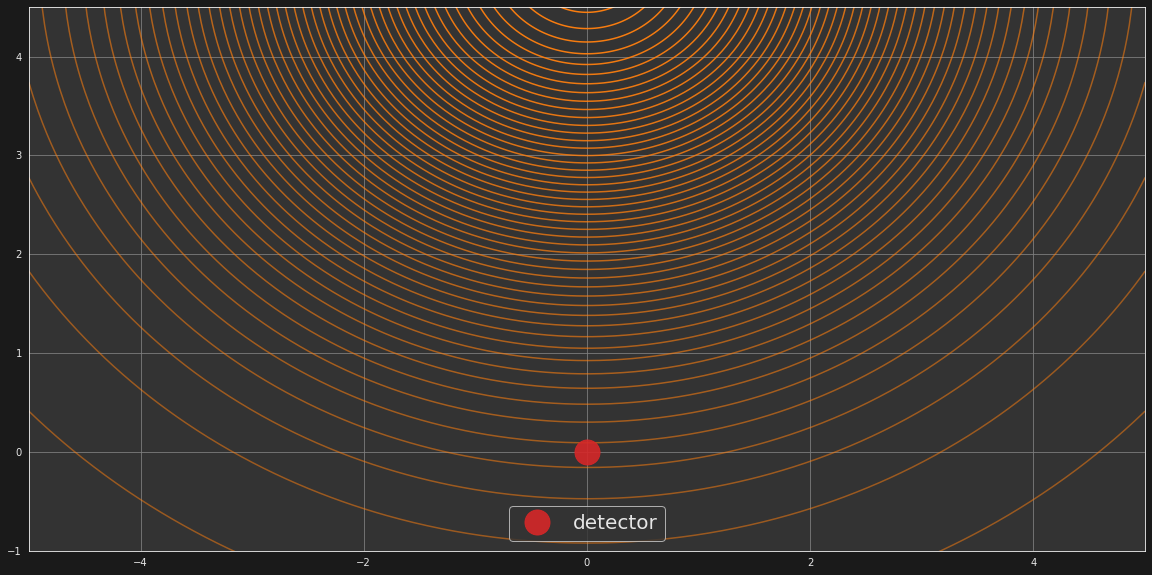

In [12]:
plot_detector(detector, node)

In [13]:
PI = 2 * torch.acos(torch.tensor(0.))
thetas = PI * torch.tensor([0.0, 0.1, -0.08]) 

In [14]:
bmcs = []
for theta in thetas:
    bmcs.append(diffpms.backward_mc(theta, node, 10)[1])

In [15]:
def plot_particles(bmc):
    for particle in bmc:
        plt.plot(particle[-1][0].numpy(), particle[-1][1].numpy(), '.C0',markersize=30, alpha=0.6)
        trajectory = torch.cat([detector.reshape(1,2), particle]).T
        plt.plot(trajectory[0].numpy(),trajectory[1].numpy(), 'C0', alpha=0.9) 
        
def plot_bmc(bmc_data, detector, node_param):
    plot_detector(detector, node_param)
    for bmc in bmc_data:
        plot_particles(bmc)

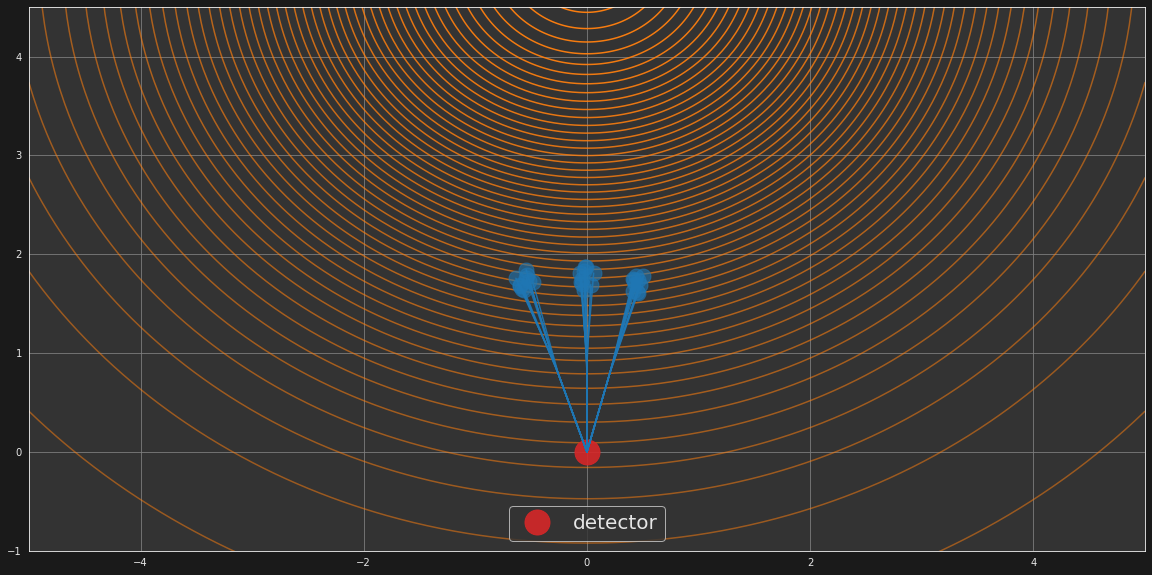

In [16]:
plot_bmc(bmcs, detector, node)

The backward Monte-Carlo algorithm takes the following form:
```cpp
inline std::tuple<Tensor, Tensor> backward_mc(
        Tensor theta,
        Tensor node,
        const int npar) {

    const auto detector = torch::zeros(2);
    const auto material_A = 0.9f;
    const auto material_B = 0.01f;

    const auto length1 = 1.f - 0.2f * torch::rand(npar);
    const auto rot1 = rot(theta);
    auto step1 = torch::stack({torch::zeros(npar), length1}).t();
    step1 = rot1.matmul(step1.view({npar, 2, 1})).view({npar, 2});
    const auto state1 = detector + step1;

    auto biasing = torch::randint(0, 2, {npar});
    auto density = mix_density(state1, node);
    auto weights =
            torch::where(biasing > 0,
                         (density / 0.5) * material_A,
                         ((1 - density) / 0.5) * material_B) * torch::exp(-0.1f * length1);

    const auto length2 = 1.f - 0.2f * torch::rand(npar);
    const auto rot2 = rot(0.05f * PI * (torch::rand(npar) - 0.5f));
    auto step2 = length2.view({npar, 1}) * step1 / length1.view({npar, 1});
    step2 = rot2.matmul(step2.view({npar, 2, 1})).view({npar, 2});
    const auto state2 = state1 + step2;

    biasing = torch::randint(0, 2, {npar});
    density = mix_density(state2, node);
    weights *=
            torch::where(biasing > 0,
                         (density / 0.5) * material_A,
                         ((1 - density) / 0.5) * material_B) * torch::exp(-0.1f * length2);

    return std::make_tuple(weights, torch::stack({state1, state2}).transpose(0, 1));
}
```

Rotations for multiple scattering are generated through:
```cpp
inline Tensor rot(const Tensor &theta) {
    const auto n = theta.numel();
    const auto c = torch::cos(theta);
    const auto s = torch::sin(theta);
    return torch::stack({c, -s, s, c}).t().view({n, 2, 2});
}
```

Simulating more trajectories we can estimate now the flux on the detector:

In [17]:
for theta in thetas:
    flux, _ = diffpms.backward_mc(theta, node, 100000)
    print(f'Flux at {round(theta.item(),2)}: {round(flux.mean().item(),6)}')

Flux at 0.0: 0.0483
Flux at 0.31: 0.042533
Flux at -0.25: 0.044675


## Differentiable Programming

We have been careful to implement the algorithms above staying compliant with all the operations provided by the `AutoGrad` engine. In fact, we have built an example of a `differentiable program`. We want to consider  the parameters of the materials mixture as our variable:

In [18]:
for theta in thetas:
    flux = diffpms.backward_mc(theta, torch.tensor([-1.0, 5.0, 10.0]), 100000)[0].mean()
    print(f'Flux at {round(theta.item(),2)}: {round(flux.item(),6)}')

Flux at 0.0: 0.040004
Flux at 0.31: 0.041408
Flux at -0.25: 0.032455


In [19]:
observed_flux = torch.tensor([0.04, 0.042, 0.032])

If the parameters are fixed, the distribution of the flux approaches a normal one with mean estimated by:
\begin{equation}
\hat\phi(\textbf{s}_f) = \frac{1}{N} \sum_{k=1}^N \omega_{k} \phi(\textbf{s}_{i,k})
\end{equation}

and variance $O(1/N)$ as the number of particles $N$ grows, which we treat as fixed for all purposes. Taking a Bayesian approach, we give a normal distribution to the prior for the parameters as well. Hence, the log-probability for observing a given value of the flux on the detector evaluates to:
```cpp
const auto log_prob_density = [thetas, observed_flux, inv_variance_flux, mean_prior, inv_variance_prior, npar](
            const vector<Tensor> &parameters) {
        const auto params = parameters.at(0).detach().requires_grad_(true);
        auto log_prob = torch::tensor(0.f);
        const auto num_thetas = thetas.numel();
        for (int i = 0; i < num_thetas; i++)
            log_prob -= inv_variance_flux *
                        (observed_flux[i] - std::get<0>(backward_mc(thetas[i], params, npar)).mean()).pow(2).sum() / 2;
        log_prob -= inv_variance_prior * (mean_prior - params).pow(2).sum() / 2;
        return std::make_tuple(log_prob, {params});
    };
```
We remind here that the `parameters` above refer to the ones defining the materials mixture. The `mean_prior` shall be the value from `node` and fixing `inv_variance_prior` depends on the application (a value of zero for example reduces the `log_prob_density` to the log-likelihood of the model).

One can feed, for example, the result of evaluating `log_prob_density` at `node` into the AD engine obtaining the value of the gradient there:
```cpp
const auto [log_prob, params] = log_prob_density({node});
const auto log_prob_grad = torch::autograd::grad({log_prob}, params)[0]
```
Let's have a look at the convergence for those calculations:

In [20]:
rng = list(range(1000,100000,1000))
log_prob, log_prob_grad = diffpms.grad_convergence_test(node, thetas, observed_flux, 1000.0, node, 1.0, list(range(1000,100000,1000)))

In [21]:
print( f'Log probability: {round(log_prob[-1].item(),6)} ~ {round(log_prob[-30:].std().item(),3)}')
print( f'Log probability: {log_prob_grad[-1]} ~ {log_prob_grad[-30:].std(0)}')

Log probability: -0.113313 ~ 0.003
Log probability: tensor([-0.0680,  1.3807, -0.2583]) ~ tensor([0.0024, 0.0259, 0.0049])


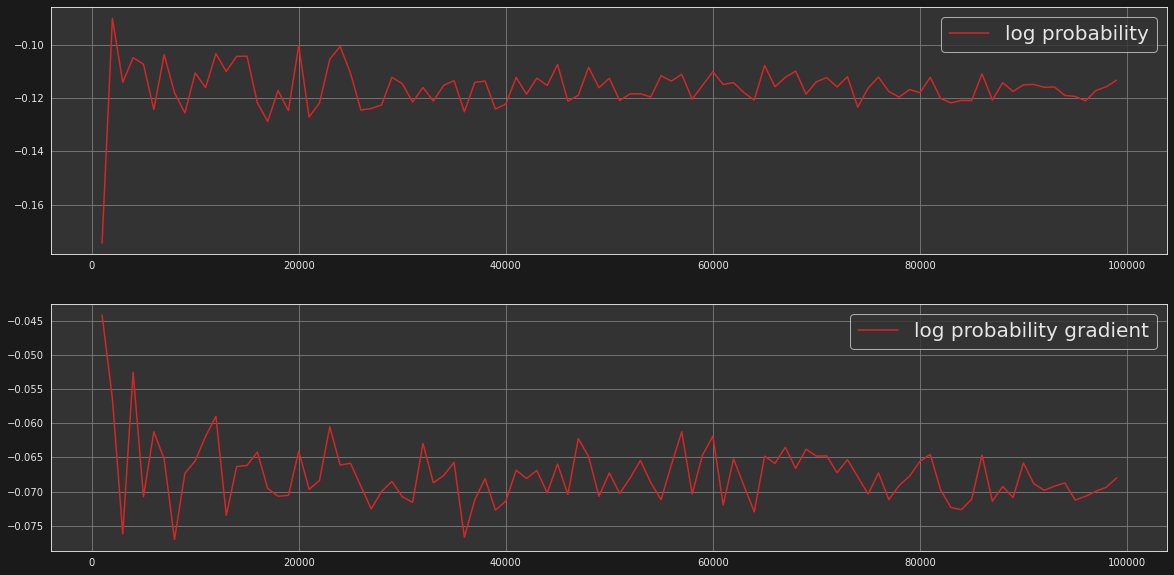

In [22]:
fig, axs = plt.subplots(2, figsize=(20,10));
axs[0].plot(torch.tensor(rng).numpy(), log_prob.numpy(), 'C3', label='log probability',alpha=0.99);
axs[0].legend(fontsize=20);
axs[1].plot(torch.tensor(rng).numpy(), log_prob_grad[:,0].numpy(), 'C3', label='log probability gradient',alpha=0.99);
axs[1].legend(fontsize=20);

We can use this now to run a Stochastic Gradient Descent (SGD) optimisation to solve the inverse problem for the `observed_flux`. This is presented as a maximum likelihood estimation setting `inv_prior_variance` to 0.  We take out the first measurement on the detector for validation later and keep in the rest for SGD. 

In [25]:
N = 1001
log_val, log_flow = diffpms.gradient_descent_bmc(thetas[1:], observed_flux[1:], node, N) 

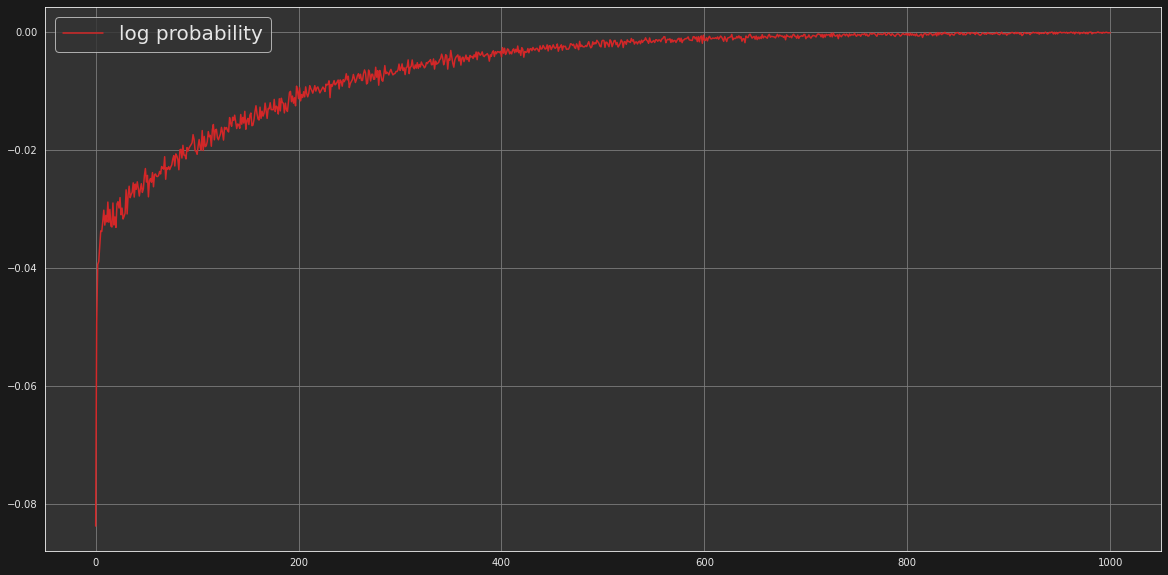

In [26]:
plt.figure(figsize=(20,10))
plt.plot(torch.arange(N).numpy(), log_val.numpy(), 'C3', label='log probability',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

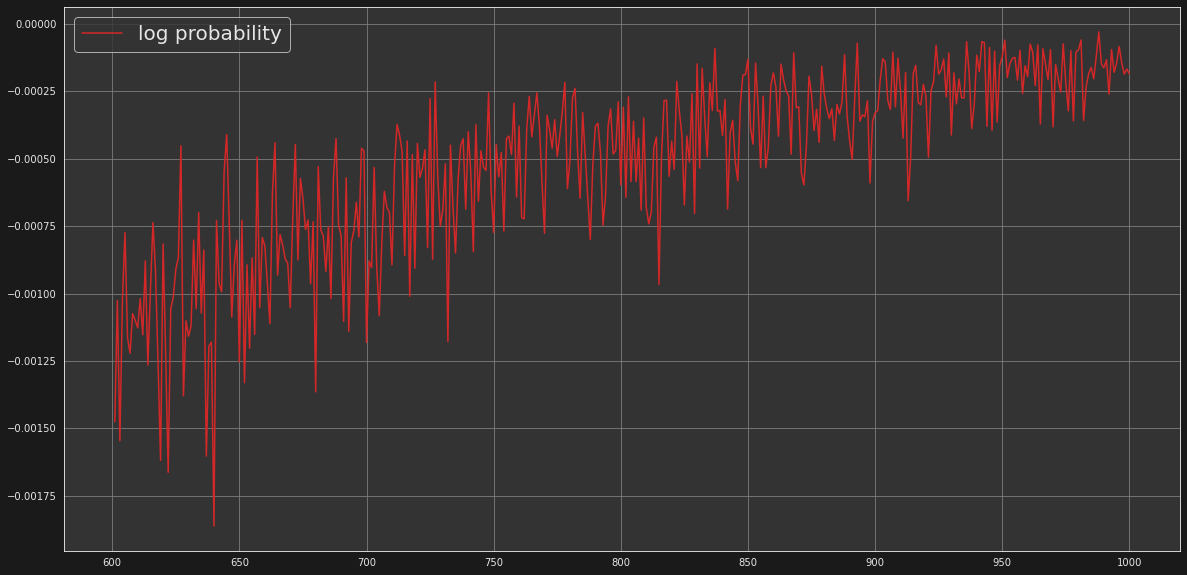

In [27]:
plt.figure(figsize=(20,10))
plt.plot(torch.arange(N).numpy()[-400:], log_val.numpy()[-400:], 'C3', label='log probability',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

In [29]:
optimal_node = log_flow[-200:].mean(0)
optimal_node

tensor([-1.0019,  4.9895,  9.9612])

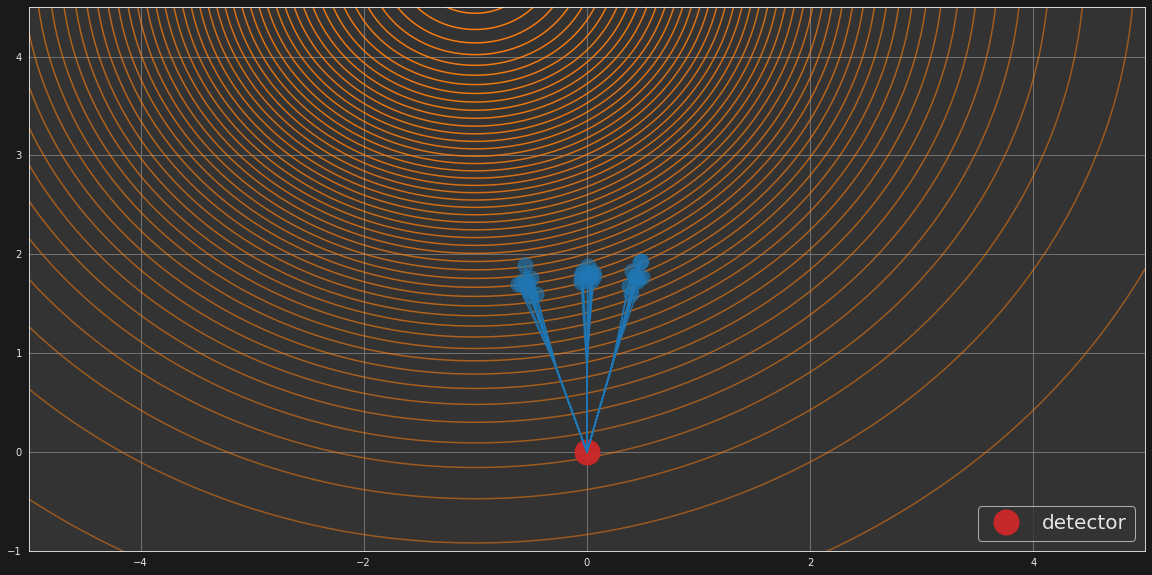

In [30]:
plot_bmc(bmcs, detector, optimal_node)

We have left out from the optimisation the measurement at angle 0. We will use it to look at the stability of the optimal solution we found with Bayesian inference. For higher dimensional distributions exhibiting rough curvature standard Markov Chain Monte-Carlo schemes are not suitable. On has to rely on Hamiltonian Monte-Carlo (HMC) which uses Hamiltonian dynamics to evolve the simulation flow:
<img src="../ghmc/hmc.png" />

Image credits: [Collin Carroll](https://colindcarroll.com/talk/hamiltonian-monte-carlo)

Note: if you are on Google Colab the image is located at `noa/docs/ghmc/hmc.png`

Our library `NOA` implements the Riemannian HMC with an explicit symplectic integrator as in:

* M. Girolami et al., *Riemann manifold Langevin and Hamiltonian Monte Carlo methods*, J. Royal Stat. Soc. Series B (Stat. Meth.) (2011)
* A. Cobb et al., *Introducing an explicit symplectic integration scheme for Riemannian manifold Hamiltonian Monte-Carlo*, preprint arXiv:1910.06243 (2018)

The Hamiltonian $H$ use the log-probability density $\mathcal{L}(\vartheta)$ as potential, where $\vartheta \in \mathbb{R}^d$ denote the parameters which we augment with momentum coordinates $\chi \in \mathbb{R}^d$:
\begin{equation}
H(\vartheta,\chi) =  \frac{1}{2} \chi^t M(\vartheta)^{-1}\chi + \frac{1}{2} \log \det(M(\vartheta)) - \mathcal{L}(\vartheta)
\end{equation}

The local metric is obtained applying a regularisation procedure in the form of the softabs map:
\begin{equation}
M = Q \cdot\lambda_d \coth (\alpha\lambda_d ) \cdot Q^t
\end{equation}
where $Q(\vartheta), \lambda_d(\vartheta)$ stand for the eigendecomposition of $\nabla^2\mathcal{L}(\vartheta)$, and typically we set $\alpha=10^6$ for the softabs constant.
Therefore, we are indirectly using the 3rd order derivative of our model for the flux. 

This Hamiltonian is non-separable, and to avoid using an implicit integrator which is computationally heavy, one can rely on the explicit algorithm from:

* M. Tao, *Explicit high-order symplectic integrators for charged particles in general electromagnetic fields*. J. of Comp. Phys. 327 (2016)

The phase space $\vartheta, \chi$ is augmented by $\vartheta^*, \chi^* \in \mathbb{R}^d$ and we solve the corresponding separable Hamiltonian dynamics:
\begin{equation}
H^*(\vartheta,\chi, \vartheta^*, \chi^*) = H(\vartheta,\chi^*) + H(\vartheta^*,\chi) + \frac{1}{2}\Omega \cdot(\|\vartheta-\vartheta^*\|^2_2 + \|\chi-\chi^*\|^2_2)
\end{equation}

where the constant $\Omega$ needs to be tuned.

One can set up the sampler in `NOA` as follows:
```cpp
const auto conf = Configuration<float>{}
            .set_max_flow_steps(max_flow_steps)
            .set_step_size(step_size)
            .set_jitter(jitter)
            .set_binding_const(binding_const)
            .set_softabs_const(1e6f)
            .set_verbosity(true);

const auto params_init = Parameters{mean_prior.detach()};

const auto ham_dym = riemannian_dynamics(log_prob_density, softabs_metric(conf), 
                                         metropolis_criterion, conf);

const auto pms_sampler = sampler(ham_dym, full_trajectory, conf);

const auto samples = pms_sampler(params_init, niter);
```

In [31]:
samples = diffpms.bayesian_backward_mc(thetas[:1], observed_flux[:1], 100.0, optimal_node, 1.0, 100000, 30, 10, 0.001, 0.0001, 10.0)
samples.shape

torch.Size([301, 3])

In [32]:
print(f'Sample mean: {samples.mean(0)}')
print(f'Sample std: {samples.std(0, True)}')

Sample mean: tensor([-1.0049,  4.9896,  9.9907])
Sample std: tensor([0.0143, 0.0104, 0.0208])


One important direction for improvement here is to introduce the appropriate form of the Stochastic Gradient HMC since the log-probability density is evaluated through backward MC. 

## Adjoint sensitivity method

There is a challenge with the above approach differentiating through the MC simulation using AD. Our algorithm is not constant in the number of steps $n$ for the discretisation of the transport. This issue can be addressed by the adjoint sensitivity method. 

For simplicity, consider an ODE: 
\begin{equation}
\frac{dx}{dt} = f(t, x(t), \theta)
\end{equation}

and imagine that we want to compute the gradient of some scalar function:
\begin{equation}
\mathcal{L}(x(t_1)) = \mathcal{L} \left( x(t_0) + \int_{t_0}^{t_1}f(t, x(t), \theta)dt\right)
\end{equation}

with respect to the parameters $\theta$. 

An efficient way to tackle this task is to introduce the adjoint:
\begin{equation}
a(t) =  \nabla_{x(t)}\mathcal{L}
\end{equation}

which satisfies the adjoint ODE:
\begin{equation}
\frac{da}{dt} = - a(t) \cdot \nabla_x f(t, x(t), \theta)
\end{equation}

The desired gradient is given then by a backward in time integral:
\begin{equation}
\nabla_{\theta}\mathcal{L} = - \int_{t_1}^{t_0} a(t) \cdot \nabla_{\theta} f(t, x(t), \theta)dt
\end{equation}

Reference: 

* L. S. Pontryagin et al., *The mathematical theory of optimal processes* (1962)

Essentially because in backward MC we simulate the evolution back from the final state, we can easily tweak the algorithm to implement the adjoint sensitivity method:
```cpp
inline std::tuple<Tensor, Tensor> backward_mc_grad(
        Tensor theta,
        Tensor node) {
    const auto npar = 1;
    const auto detector = torch::zeros(2);
    auto bmc_grad = torch::zeros_like(node);

    const auto material_A = 0.9f;
    const auto material_B = 0.01f;

    const auto length1 = 1.f - 0.2f * torch::rand(npar);
    const auto rot1 = rot(theta);
    auto step1 = torch::stack({torch::zeros(npar), length1}).t();
    step1 = rot1.matmul(step1.view({npar, 2, 1})).view({npar, 2});
    const auto state1 = detector + step1;

    auto biasing = torch::randint(0, 2, {npar});

    auto node_leaf = node.detach().requires_grad_();
    auto density = mix_density(state1, node_leaf);
    auto weights_leaf =
            torch::where(biasing > 0,
                         (density / 0.5) * material_A,
                         ((1 - density) / 0.5) * material_B) * torch::exp(-0.01f * length1);
    bmc_grad += torch::autograd::grad({weights_leaf}, {node_leaf})[0];
    auto weights = weights_leaf.detach();

    const auto length2 = 1.f - 0.2f * torch::rand(npar);
    const auto rot2 = rot(0.05f * PI * (torch::rand(npar) - 0.5f));
    auto step2 = length2.view({npar, 1}) * step1 / length1.view({npar, 1});
    step2 = rot2.matmul(step2.view({npar, 2, 1})).view({npar, 2});
    const auto state2 = state1 + step2;

    biasing = torch::randint(0, 2, {npar});

    node_leaf = node.detach().requires_grad_();
    density = mix_density(state2, node_leaf);
    weights_leaf =
            torch::where(biasing > 0,
                         (density / 0.5) * material_A,
                         ((1 - density) / 0.5) * material_B) * torch::exp(-0.01f * length2);
    const auto weight2 = weights_leaf.detach();
    bmc_grad = weights * torch::autograd::grad({weights_leaf}, {node_leaf})[0] + weight2 * bmc_grad;
    weights *= weight2;

    return std::make_tuple(weights, bmc_grad);
}
```

In [164]:
torch.manual_seed(10)
diffpms.backward_mc_grad(thetas[0], knode)

(tensor([0.0042]), tensor([ 8.2982e-06, -1.8718e-03,  4.5535e-04]))